In [25]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

In [26]:
test_results = pd.read_csv('test_results.csv')
test_results

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0
...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0


In [27]:
users = pd.read_csv('user_table.csv')
users

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68
...,...,...,...,...,...
275611,485975,Atlanta,USA,33.76,-84.42
275612,35479,Los Angeles,USA,34.11,-118.41
275613,516519,Chicago,USA,41.84,-87.68
275614,984877,Tampa,USA,27.96,-82.48


In [28]:
# add user information from users table to the test_results table
test_merged = pd.merge(test_results, users, how='left', on='user_id')
test_merged

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02
...,...,...,...,...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0,Bell Gardens,USA,33.97,-118.15
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0,West Seneca,USA,42.84,-78.75
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0,Walnut Creek,USA,37.90,-122.04


In [35]:
def hypothesis_test_t(sample1, sample2, alpha=0.05):
    # Calculate sample statistics
    n1 = len(sample1)
    n2 = len(sample2)
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    var1 = np.var(sample1, ddof=1)
    var2 = np.var(sample2, ddof=1)
    
    # Calculate pooled standard error
    pooled_se = np.sqrt(var1/n1 + var2/n2)
    
    # Calculate t-statistic
    t_stat = (mean2 - mean1) / pooled_se
    
    # Calculate degrees of freedom (Welch–Satterthwaite equation)
    df = ((var1/n1 + var2/n2)**2) / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))
    
    # Calculate standard error for confidence interval
    se = np.sqrt((var1/n1) + (var2/n2))
    
    # Calculate confidence interval
    ci_lower = (mean2 - mean1) - (2.0 * se)
    ci_upper = (mean2 - mean1) + (2.0 * se)
    
    return {
        't_statistic': t_stat,
        'degrees_of_freedom': df,
        'difference': mean2 - mean1,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

In [36]:
def ab_test_by_source(test_merged):
    results = []
    
    for source in test_merged['source'].unique():
        # Filter data for current source
        source_data = test_merged[test_merged['source'] == source]
        
        # Get data for each price group
        price_39_data = source_data[source_data['price'] == 39]['converted']
        price_59_data = source_data[source_data['price'] == 59]['converted']
        
        # Calculate basic statistics
        n1 = len(price_39_data)
        n2 = len(price_59_data)
        conv_rate_39 = np.mean(price_39_data)
        conv_rate_59 = np.mean(price_59_data)
        
        # Calculate standard errors
        se_39 = np.sqrt(conv_rate_39 * (1 - conv_rate_39) / n1)
        se_59 = np.sqrt(conv_rate_59 * (1 - conv_rate_59) / n2)
        
        # Skip if sample size is too small
        if n1 < 30 or n2 < 30:
            continue
        
        # Perform hypothesis test
        test_results = hypothesis_test_t(price_39_data, price_59_data)
        
        # Calculate p-value using t-distribution
        p_value = 2 * (1 - t.cdf(abs(test_results['t_statistic']), 
                                df=test_results['degrees_of_freedom']))
        
        results.append({
            'source': source,
            'conversion_rate_39': conv_rate_39,
            'conversion_rate_59': conv_rate_59,
            'sample_size_39': n1,
            'sample_size_59': n2,
            'difference': test_results['difference'],
            't_statistic': test_results['t_statistic'],
            'degrees_of_freedom': test_results['degrees_of_freedom'],
            'p_value': p_value,
            'ci_lower': test_results['ci_lower'],
            'ci_upper': test_results['ci_upper'],
            'se_39': se_39,
            'se_59': se_59
        })
    
    return pd.DataFrame(results)


In [37]:
# Run the analysis
results_df = ab_test_by_source(test_merged)

# Sort by absolute difference in conversion rates
results_df['abs_difference'] = abs(results_df['difference'])
results_df = results_df.sort_values('abs_difference', ascending=False)

# Add significance indicator
results_df['significant'] = results_df['p_value'] < 0.05

# Format the results for display
display_df = results_df.round(4)
print("\nTest Results:")
print(display_df)



Test Results:
             source  conversion_rate_39  conversion_rate_59  sample_size_39  \
10         seo-bing              0.0300              0.0134            1333   
9         seo-yahoo              0.0195              0.0104            4356   
6   friend_referral              0.0417              0.0335           13124   
0      ads_facebook              0.0236              0.0169           34090   
8         ads-yahoo              0.0168              0.0112            4818   
11        seo-other              0.0175              0.0124            5885   
5      seo_facebook              0.0174              0.0136           13473   
2          ads-bing              0.0134              0.0096           14601   
3    direct_traffic              0.0135              0.0102           38750   
7         ads_other              0.0155              0.0124           19278   
4        ads-google              0.0226              0.0196           37863   
1        seo-google              0.01

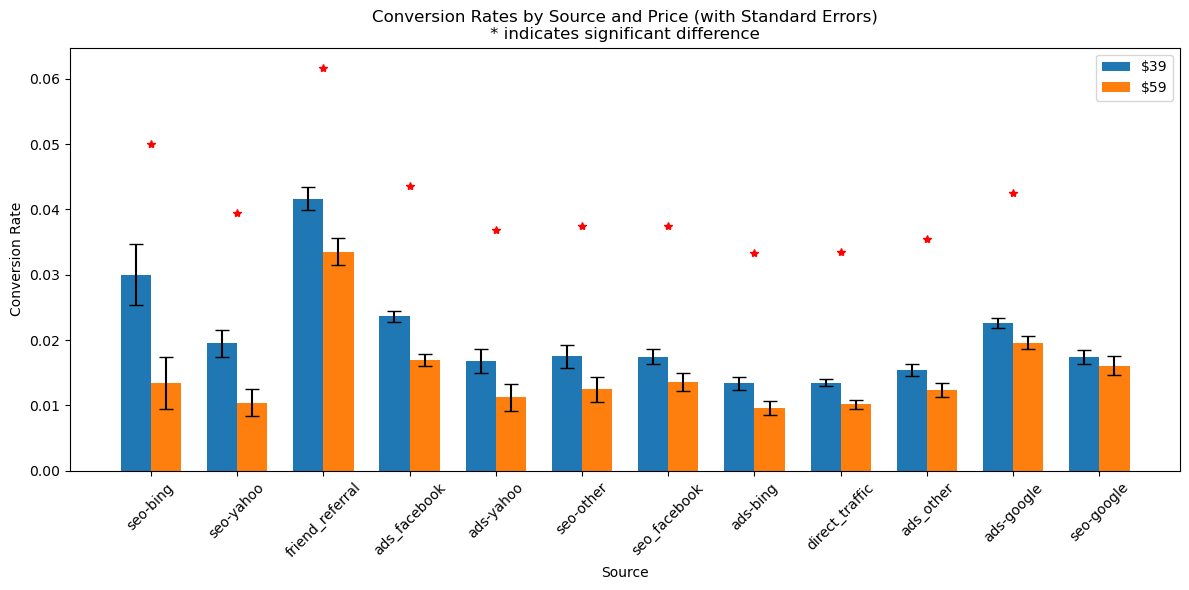

In [38]:
# Visualization
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

# Create bars
plt.bar(x - width/2, results_df['conversion_rate_39'], width, label='$39')
plt.bar(x + width/2, results_df['conversion_rate_59'], width, label='$59')

# Add error bars for both groups
plt.errorbar(x - width/2, results_df['conversion_rate_39'], 
            yerr=results_df['se_39'],
            fmt='none', color='black', capsize=5)
plt.errorbar(x + width/2, results_df['conversion_rate_59'], 
            yerr=results_df['se_59'],
            fmt='none', color='black', capsize=5)

# Add significance markers
for i, is_sig in enumerate(results_df['significant']):
    if is_sig:
        plt.plot(i, max(results_df['conversion_rate_39'].iloc[i], 
                       results_df['conversion_rate_59'].iloc[i]) + 0.02, 
                '*', color='red')

plt.xlabel('Source')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Source and Price (with Standard Errors)\n* indicates significant difference')
plt.xticks(x, results_df['source'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()